## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

In [246]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.datasets import load_sample_image
from mpl_toolkits.mplot3d import Axes3D
import random
import copy 
from scipy.stats import multivariate_normal

%matplotlib inline

def compare_images(img, img_compressed, k):
    """Show the compressed and uncompressed image side by side.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes[0].set_axis_off()
    if isinstance(k, str):
        axes[0].set_title(k)
    else:
        axes[0].set_title(f"Compressed to {k} colors")
    axes[0].imshow(img_compressed)
    axes[1].set_axis_off()
    axes[1].set_title("Original")
    axes[1].imshow(img)

# K-Means

In this first section you will implement the image compression algorithm from Bishop, chapter 9.1.1. Take an RGB image $X \in \mathbb{R}^{h \times w \times 3}$ and interpret it as a data matrix $X \in \mathbb{R}^{N \times 3}$. Now apply $k$-means clustering to find $k$ colors that describe the image well and replace each pixel with its associated cluster.

In [198]:
# Alternatively try china.jpg
X = load_sample_image("flower.jpg")
X.shape

# or load your own image
# X = np.array(Image.open("/home/user/path/to/some.jpg"))

(427, 640, 3)

In [199]:
# Test
print(X[1,1,:])
print(X[1,2,:])
k = 5
h = X.shape[0]
w = X.shape[1]
N = h * w # # of data pts
D = X.shape[2] # # of data features
x = X.reshape([-1,3])
print(x.shape)
y = x[:500,:]
print(y.shape)
# Generate random centroid, here we use sigma and mean to ensure it represent the whole data
# mean = np.mean(x, axis = 0)
# print(mean)
# std = np.std(x, axis = 0)

# centers = np.random.randn(k,D)*std + mean

# print(centers)

# centroids = [] 
# centroids.append(y[np.random.randint( 
#         y.shape[0]), :])
# print(centroids[0])
# print(centroids[0][0],centroids[0][1],centroids[0][2])

[ 3 18 13]
[ 7 20 13]
(273280, 3)
(500, 3)


In [200]:
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter(y[:,0], y[:,1], y[:,2])
# centroids = [] 
# centroids.append(y[np.random.randint( 
#         y.shape[0]), :])
# print(centroids[0])
# ax.scatter(centroids[0][0],centroids[0][1],centroids[0][2], c='r', marker='*',s=200)
# plt.show()


In [220]:
# N = y.shape[0]
# m = np.arange(N)
# print(m)
def initialize(data, k): 
    ''' 
    intialized the centroids for K-means++ 
    inputs: 
        data - numpy array of data points having shape (200, 2) 
        k - number of clusters  
    '''
    N = data.shape[0]
    data_index = np.arange(N)
#     fig = plt.figure()
#     ax = Axes3D(fig)
#     ax.scatter(data[:,0], data[:,1], data[:,2])
   
    centroids = []
    centroids.append(data[np.random.randint(data.shape[0]), :])
#     print(centroids)
#     ax.scatter(centroids[0][0],centroids[0][1],centroids[0][2], c='r', marker='*',s=200)
    
    for c_id in range(k - 1):       
            ## initialize a list to store distances of data 
            ## points from nearest centroid 
        dist = [] 
        for i in range(data.shape[0]): 
            point = data[i, :] 
            d = 1000000000

            ## compute distance of 'point' from each of the previously 
            ## selected centroid and store the minimum distance 
            for j in range(len(centroids)): 
                temp_dist = (np.linalg.norm(point-centroids[j]))**2
                d = min(d, temp_dist) 
            dist.append(d)
        ## select data point with maximum distance as our next centroid 
        dist = np.array(dist)
        P_dist = dist / sum(dist)
        index_next_centroid = np.random.choice(data_index, size=1, p=P_dist )
        next_centroid = data[index_next_centroid,:].reshape(-1)
#         next_centroid = data[np.argmax(dist), :] 
#         print(next_centroid)
        centroids.append(next_centroid)
#         ax.scatter(next_centroid[0],next_centroid[1],next_centroid[2], c='g', marker='*',s=200)
        dist = [] 
#         print(len(centroids))
    centroids = np.array(centroids)
    print(centroids)
    return centroids

In [221]:
centroids = initialize(y, k = 4)
# centroids = np.array(centroids)
# print(centroids)

[[ 2 69 36]
 [ 0 65 73]
 [ 3 24 19]
 [ 0 59 27]]


In [222]:
def kmeans(X, k):
    """Compute a k-means clustering for the data X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
        
    Returns
    -------
    mu : np.array of size k x D
        Cluster centroids
    z : np.array of size N
        Cluster indicators, i.e. a number in 0..k - 1, for each data point in X
    """
    
    # TODO: Compute mu and z
    
    # initialize mu with k-means ++
    centroids = initialize(X, k)
#     print(centroids)
    
    # k-means
    centroids_old = np.zeros(centroids.shape) # to store old centroids
    centroids_new = copy.deepcopy(centroids) # Store new centroids

    X.shape
    n = X.shape[0]
    clusters = np.zeros(n)
    distances = np.zeros((n,k))

    error = np.linalg.norm(centroids_new - centroids_old)

    # When, after an update, the estimate of that center stays the same, exit loop
    while error != 0:
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - centroids[i], axis=1)
        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)

        centroids_old = copy.deepcopy(centroids_new)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            centroids_new[i] = np.mean(X[clusters == i], axis=0)
        error = np.linalg.norm(centroids_new - centroids_old)
    mu = centroids_new
    z = clusters

    return mu, z

In [223]:
mu, z = kmeans(y, k = 4)
print(mu)


[[ 4 37 30]
 [ 5 30 24]
 [ 3 24 17]
 [ 0 58 59]]
[[20 57 47]
 [ 5 43 30]
 [ 5 37 24]
 [ 4 64 59]]


[[190  85  28]
 [  0  52  63]
 [  1  44  25]
 [  0  41  35]
 [238 202 150]]


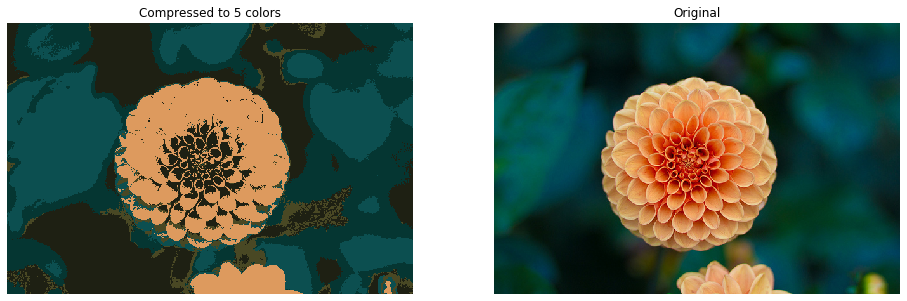

In [224]:
# Cluster the color values
k = 5
mu, z = kmeans(X.reshape((-1, 3)), k)

# Replace each pixel with its cluster color
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Gaussian Mixture Models & EM

Now you will repeat the same exercise with GMMs.

In [382]:
def gmm_log_probability(X, pi, mu, sigma):
    """Compute the joint log-probabilities for each data point and component.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    P : np.array of shape N x k
        P[i, j] is the joint log-probability of data point i under component j
    """
    
    # TODO: Compute P

    
    return P
    

def em(X, k, tol=0.001):
    """Fit a Gaussian mixture model with k components to X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
    tol : float
        Converge when the increase in the mean of the expected joint log-likelihood
        is lower than this
        
    The algorithm should stop when the relative improvement in the optimization
    objective is less than rtol.
    
    Returns
    -------
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    """
    ######################## initial ###################### 
    N = X.shape[0]
    D = X.shape[1]
    number_of_sources = k
    mu = np.random.randint(min(X[:,0]),max(X[:,0]),size=(number_of_sources,len(X[0]))) 
    # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
    sigma = np.zeros((number_of_sources,len(X[0]),len(X[0]))) 
    # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
    for dim in range(len(sigma)):
        np.fill_diagonal(sigma[dim],5)
    
    pi = np.ones(number_of_sources)/number_of_sources # Are "Fractions"
#     pi = pi.reshape((-1,1))
                    
    p_joint = np.zeros([N,k])# p_joint = P(Xi and Cluster_k)
    gamma =np.zeros(pi.shape) 
    for c in range(k):
        print("k = ", c+1)
        p_joint[:,c] = pi[c] * multivariate_normal.pdf(X, mean = mu[c,:], cov = sigma[c,:,:] );
    
#     print("p_joint.shape = ", p_joint.shape)
#     print("p_joint[:3,:] = \n", p_joint[:3,:])
    p_joint = p_joint + 1e-10
#     print("min p_joint = ", np.min(p_joint))
    sum_p_joint = np.sum(p_joint,axis = 1)
    sum_p_joint = sum_p_joint.reshape((-1,1))
    
#     print("sum_p_joint.shape = ", sum_p_joint.shape)
    gamma = p_joint/sum_p_joint
#     print("gamma.shape = ", gamma.shape)
#     print("gamma[273270:273279,:] = \n", gamma[273270:273279,:])
    ######################## initial End ###################### 
    for j in range(4):
        Nk = np.sum(gamma,axis = 0)
        Nk = Nk.reshape((-1,1))
#         print("Nk.shape = ", Nk.shape)
        pi_next = np.squeeze(Nk/N)
#         print("pi_next.shape = ", pi_next.shape)

        mu_next  = gamma.T.dot(X)/Nk
#         print("mu_next.shape = ", mu_next.shape)

        sigma_tmp = np.zeros((k,N,D,D))
        for c in range(k):
            sigma_mid = np.array((X-mu[c,:]).T.dot(X-mu[c,:]))
            sigma_tmp[c,:,:,:] = np.multiply.outer(gamma[:,c], sigma_mid)
        sigma_tmp_sumk = np.sum(sigma_tmp,axis = 0)
        sigma_tmp_sumN = np.sum(sigma_tmp_sumk,axis = 0)
        sigma_next = np.squeeze(np.multiply.outer(1/pi, sigma_tmp_sumN))
#         print("sigma_mid.shape = ", sigma_mid.shape)
#         print("sigma_tmp_sumk.shape =", sigma_tmp_sumk.shape)
#         print("sigma_tmp_sumN.shape =", sigma_tmp_sumN.shape)
#         print("sigma_next.shape =", sigma_next.shape)
        pi = pi_next
        print("pi @ ",j ," = ", pi )
        mu = mu_next
        print("mu @ ",j ," = \n", mu )
        sigma = sigma_next

        # update gamma
        for c in range(k):
    #         print("k = ", c+1)
            p_joint[:,c] = pi[c] * multivariate_normal.pdf(X, mean = mu[c,:], cov = sigma[c,:,:] );

    #     print("p_joint.shape = ", p_joint.shape)
    #     print("p_joint[:3,:] = \n", p_joint[:3,:])
        p_joint = p_joint + 1e-10
    #     print("min p_joint = ", np.min(p_joint))
        sum_p_joint = np.sum(p_joint,axis = 1)
        sum_p_joint = sum_p_joint.reshape((-1,1))
    #     print("sum_p_joint.shape = ", sum_p_joint.shape)
        gamma_next = p_joint/sum_p_joint
        print("gamma_next.shape = ", gamma_next.shape)
        gamma = gamma_next

    

    return pi, mu, sigma

In [383]:
x0 = X.reshape((-1, 3))
len(x0[0])
# Fit the GMM
k = 5
pi, mu, sigma = em(X.reshape((-1, 3)), k)
print("sigma.shape = ", sigma.shape)
print("mu.shape = ", mu.shape, "\nmu =\n", mu )
print("pi = \n", pi)

# G = 5 * np.ones((5,3))
# g = 1 * np.ones((1,3))
# print(G-g)



k =  1
k =  2
k =  3
k =  4
k =  5
pi @  0  =  [0.2 0.2 0.2 0.2 0.2]
mu @  0  = 
 [[55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]]
gamma_next.shape =  (273280, 5)
pi @  1  =  [0.2 0.2 0.2 0.2 0.2]
mu @  1  = 
 [[55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]]
gamma_next.shape =  (273280, 5)
pi @  2  =  [0.2 0.2 0.2 0.2 0.2]
mu @  2  = 
 [[55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]]
gamma_next.shape =  (273280, 5)
pi @  3  =  [0.2 0.2 0.2 0.2 0.2]
mu @  3  = 
 [[55.13415179 73.57890076 57.00021224]
 [55.13415179 73.57890076 57.00021224]
 [55.13415179 7

In [359]:
a = np.ones((2,2))
b = np.array([1,2,3])
d = 1/b
print(d)
c = np.multiply.outer(b, a)
print("c.shape = ", c.shape)
# print("c = \n", c)
# G = 5 * np.ones((1,3,3))
# g = 2 * np.ones(5)
# print(G/g)

[1.         0.5        0.33333333]
c.shape =  (3, 2, 2)


In [310]:
# Fit the GMM
k = 5
pi, mu, sigma = em(X.reshape((-1, 3)), k)

# Determine the most likely cluster of each pixel
log_p = gmm_log_probability(X.reshape((-1, 3)), pi, mu, sigma)
z = log_p.argmax(axis=1)

# Replace each pixel with its cluster mean
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

k =  1
k =  2
k =  3
k =  4
k =  5
p_joint.shape =  (273280, 5)
p_joint[:3,:] = 
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
min p_joint =  1e-10
sum_p_joint.shape =  (273280, 1)
gamma.shape =  (273280, 5)
gamma[273270:273279,:] = 
 [[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
pi_next.shape =  (5, 1)
mu_next.shape =  (5, 3)


NameError: name 'P' is not defined

# Sampling Unseen Datapoints

You have trained a generative model which allows you to sample from the learned distribution. In this section, you sample new images.

(427, 640, 3)

In [ ]:
def gmm_sample(N, pi, mu, sigma):
    """Sample N data points from a Gaussian mixture model.
    
    Parameters
    ----------
    N : int
        Number of data points to sample
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    X : np.array of shape N x D
    """
    
    # TODO: Sample X
    
    return X

In [ ]:
# Sample pixels and reshape them into the size of the original image
X_sampled = gmm_sample(np.prod(X.shape[:-1]), pi, mu, sigma).reshape(X.shape).astype(np.uint8)

# Compare the original and the sampled image
compare_images(X, X_sampled, "Sampled")

Explain what you see in the generated images. (1-3 sentences)